##### Working FIle for explainability in machine learning 

- main goal is to delineate model explainability between Shap, Lime and GAM
- This will act as a shell file on the Austrailian Credit Approval Data until Cap One data is readily available

Import stuff

In [44]:
from helpful_util import *
import pandas_profiling
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 5, 5

#files, main_dir = list_dir()
#main_dir
    

In [56]:
data_path = fetch_data_path(folder = 'data') #Using UDF to fetch data

Choose a file from data directory:
0) australian.dat
1) australian.doc
2) ~$stralian.doc
Enter Number: 0
Path to Data Stored: C:\Users\jdine\Documents\1.MachineLearning\hicss2020-master\data\australian.dat


In [57]:
import pandas as pd
import numpy as np
import matplotlib 
data_path
cols = [("A" + str(i)) for i in range(1,16)] #Arbitrary Column Naming
df = pd.read_csv(data_path, header = None, delimiter= " ", names= cols) #Create DF. Reading in a .dat file with tab delimeter

df.head()



,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [58]:
pandas_profiling.ProfileReport(df) #Neat tool for quick EDA

Number of variables,15
Number of observations,690
Total Missing (%),0.0%
Total size in memory,80.9 KiB
Average record size in memory,120.1 B
Numeric,10
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,0


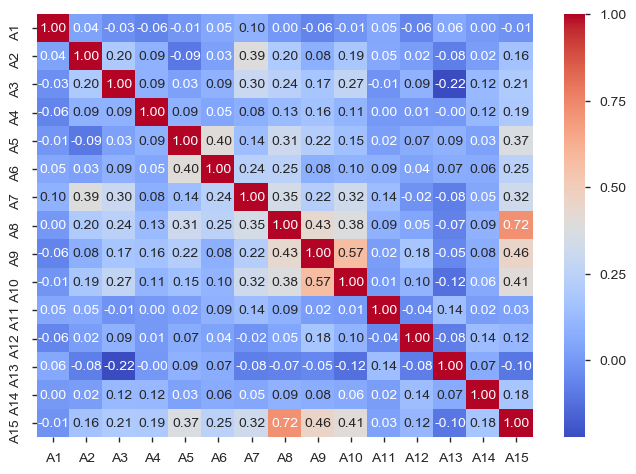

In [41]:
import seaborn as sns

g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [59]:
from collections import Counter

 
Outliers_to_drop = detect_outliers(df,1,["A2","A3","A5","A7"])
df.loc[Outliers_to_drop]
df = df.drop(df.index[Outliers_to_drop]) #Remove outliers based on Tukey method

In [13]:
##Using Heaton's Utils
#Built in OHE of explanatory
#!pip install requests
#Use this if we want to OHE dependent var
from heaton_utils import *
X, y = to_xy(df, 'A15')

In [52]:
import sklearn
from sklearn.model_selection import train_test_split
X, y = df.iloc[:,:-1], df.iloc[:,-1] #Split Dependent / Independent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = True, random_state = 123) #Train Test Split




In [53]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import multilayer_perceptron
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

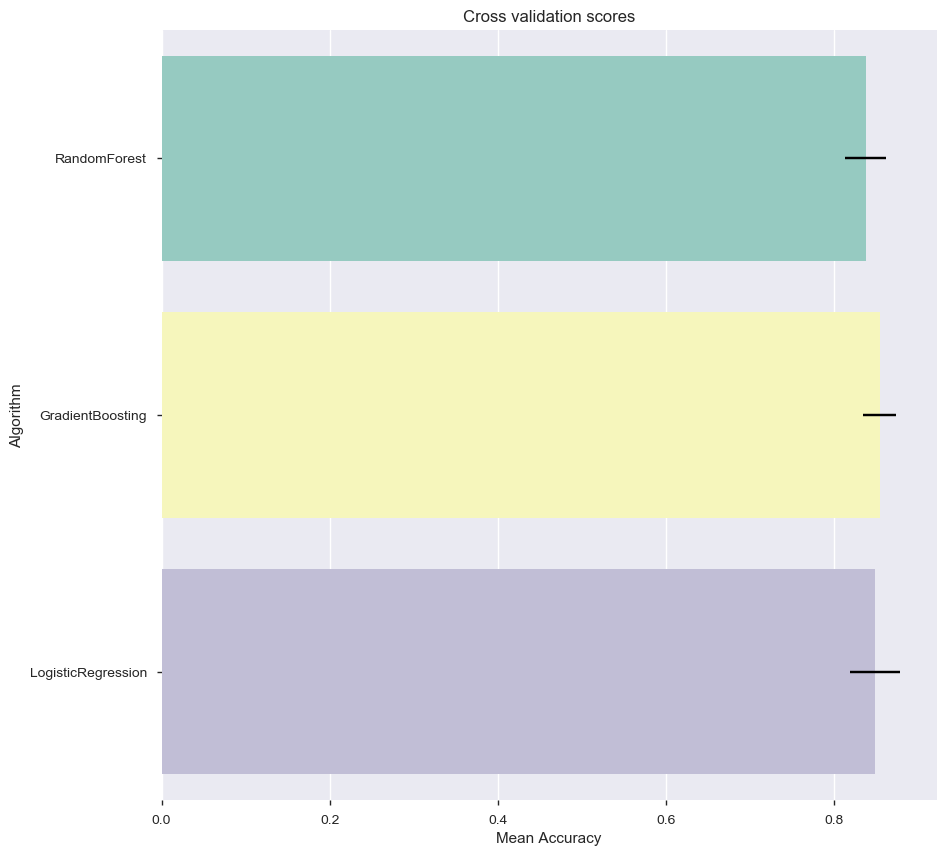

In [54]:
import seaborn as sns
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":[
"RandomForest","GradientBoosting","LogisticRegression"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [55]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print("RF Best Score: {}".format(gsRFC.best_score_))

# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_
print("GBC Best Score: {}".format(gsGBC.best_score_))

#Sklearn Logit Regression
LR = LogisticRegression()
LR_param_grid = {
    'penalty' : ['l1', 'l2']}

gsLR = GridSearchCV(LR, param_grid=LR_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsLR.fit(X_train,y_train)
LR_best = gsLR.best_estimator_

gsLR.best_score_
print("Logit Best Score: {}".format(gsLR.best_score_))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF Best Score: 0.8763837638376384
Fitting 5 folds for each of 72 candidates, totalling 360 fits
GBC Best Score: 0.8782287822878229
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Logit Best Score: 0.8579335793357934


[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    4.0s finished
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\l

In [ ]:
import keras
from keras import 